In [3]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [4]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [5]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, quantile_transform

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [8]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [9]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [10]:
df

,Sequence,MIC
0,AAQRRGRVGRNPNQVGD,442.00000
1,HRILARIRQMMT,435.50000
2,RNPSQVGD,383.00000
3,RVGRNPNQVGD,374.00000
4,AAQRRGRIGRNPSQVGD,358.00000
...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008


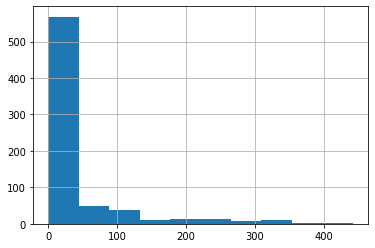

In [11]:
df['MIC'].hist()

In [12]:
df['pIC50'] = df['MIC'].apply(lambda x: -np.log(x*1e-6))

In [13]:
df

,Sequence,MIC,pIC50
0,AAQRRGRVGRNPNQVGD,442.00000,7.724201
1,HRILARIRQMMT,435.50000,7.739016
2,RNPSQVGD,383.00000,7.867476
3,RVGRNPNQVGD,374.00000,7.891255
4,AAQRRGRIGRNPSQVGD,358.00000,7.934978
...,...,...,...
707,NGAICWGPCPTAFRQIGNCGHFKVRCCKIR,0.11515,15.977030
708,CFPYITRPGTYHDWWYTRKNRQ,0.30000,15.019483
709,YTSLIHSLIEESQNQQEKNEQELLELDKWASLWNWF,0.01131,18.297579
710,GTNLSVPNPLGFFPDHQLDPAFGANSNNPDWDFNPNKDHWPEANKVG,0.00008,23.248994


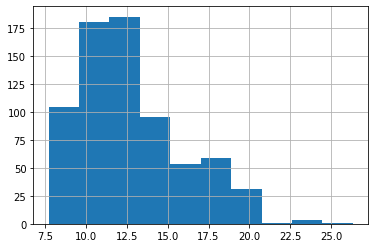

In [14]:
df['pIC50'].hist()

In [26]:
df['MIC'].to_frame()

,MIC
0,442.00000
1,435.50000
2,383.00000
3,374.00000
4,358.00000
...,...
707,0.11515
708,0.30000
709,0.01131
710,0.00008


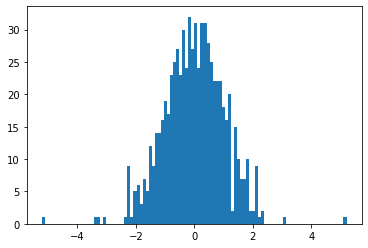

In [41]:
y_trans = quantile_transform(df['MIC'].to_frame(), n_quantiles=50, output_distribution='normal', copy=True)
h = plt.hist(y_trans, bins=100)

In [42]:
df['quant'] = y_trans

In [15]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [16]:
aa_freq = reduce_by_kmer_frequency(df)

In [17]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1190.09sequence/s]


In [18]:
physicochemical_prop = get_physicochemical_properties(df)

In [19]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [43]:
y = df[['MIC']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
regr = TransformedTargetRegressor(regressor=SVR(C=100, gamma=3), 
                                 transformer=QuantileTransformer(n_quantiles=900, output_distribution='normal')
                                )

In [48]:
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2370: UserWarning: n_quantiles (900) is greater than the total number of samples (569). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [49]:
ape = 100*np.abs(y_test-y_pred)/y_test

In [64]:
ape.values.squeeze().mean()

2843368.6056035724